In [41]:
import numpy as np
import torch
import torch.nn as nn
import scipy
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import torch.utils.data as data_utils
import sys

#### Define the ODE

In [42]:
alpha, beta, gamma, delta = (1.3,0.9,0.8,1.8)
x0, y0 = (0.44249296, 4.6280594)
# time_int = [0,3]

In [43]:
class LotkaVolterraSystem:
    def __init__(self, alpha, beta, delta, gamma, X):
        self.alpha, self.beta, self.delta, self.gamma = alpha, beta, delta, gamma
        self.X = X
        
    def model(X, t, alpha, beta, delta, gamma):
        x, y = X
        dxdt = x * (alpha - beta * y)
        dydt = y * (-delta + gamma * x)
        return np.array([dxdt, dydt])
    
    def solve(self, t):
        res = odeint(LotkaVolterraSystem.model, self.X, t, args = (self.alpha, self.beta, self.delta, self.gamma))
        return res

In [44]:
LV = LotkaVolterraSystem(alpha=alpha, beta=beta, delta=delta, gamma=gamma, X=[x0,y0])

In [45]:
# Get numerical solutions in the range [0,3]
t_phys_int = [0,3]
Np_phys = 10**3
t_phys = torch.linspace(t_phys_int[0], t_phys_int[1], Np_phys)

sol_phys = LV.solve(t=t_phys)
x_phys, y_phys = sol_phys.T
t_phys = t_phys.requires_grad_(True)

In [46]:
# Noises

# eps = 5e-3 # for the first experiment
# eps = 0
# eps = 8e-3
# eps = 1e-2
# eps = 3e-2
eps = 5e-2
# eps = 8e-2
# eps = 1e-1

In [47]:

def get_noisy_measurements(n, xi, yi, t, eps):
    '''
    Returns n equally spaced noisy measurements from xi,yi
    '''
    bar_x = np.mean(xi)
    bar_y = np.mean(yi)
    
    assert n <= len(t)
    
    step = len(t)//n

    indices = np.arange(0, len(t), step)[:n]

    x = xi[indices]
    y = yi[indices]
    x = x + eps * bar_x * np.random.normal(loc=0.0, scale=1.0, size=len(x))
    y = y + eps * bar_y * np.random.normal(loc=0.0, scale=1.0, size=len(y))
    
    return torch.vstack([torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)]), t[indices].clone().detach()

In [48]:
# get training data

spacing = 0.1
num_points = int(t_phys_int[1] /spacing)

print(f'Number of points: {num_points}')
print(f'Noise level: {eps}')
measurements, measurements_t = get_noisy_measurements(num_points, x_phys, y_phys, t_phys, eps)

Number of points: 30
Noise level: 0.05


Text(0.5, 1.0, 'Test ')

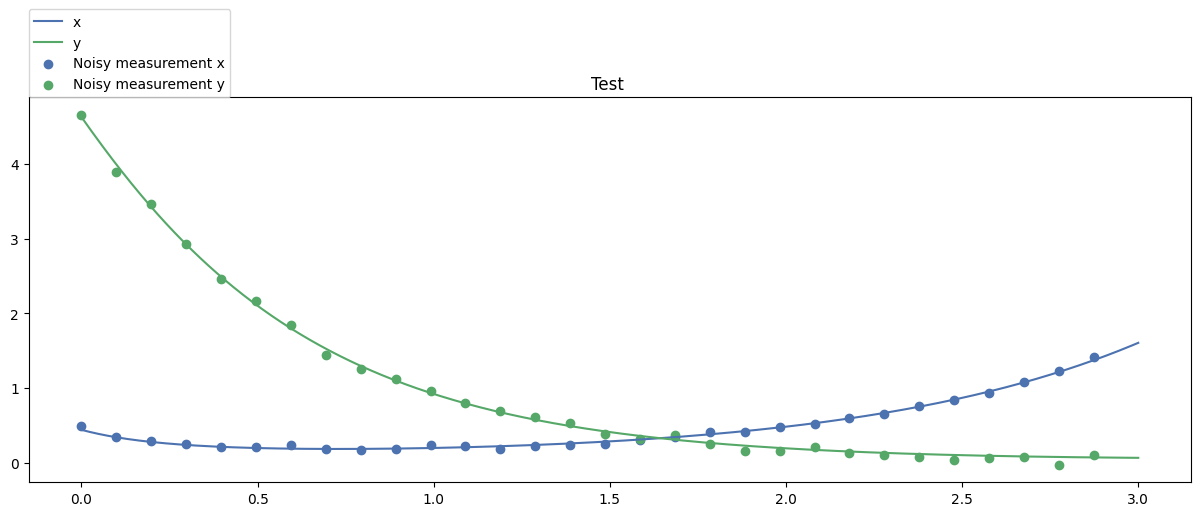

In [49]:
plt.style.use("seaborn-v0_8-deep")
fig, ax = plt.subplots(1, figsize=(15,5))
ax.plot(t_phys.detach().numpy(), x_phys, label='x')
ax.plot(t_phys.detach().numpy(), y_phys, label='y')
ax.scatter(measurements_t.detach().numpy(), measurements[0,:], label='Noisy measurement x')
ax.scatter(measurements_t.detach().numpy(), measurements[1,:], label='Noisy measurement y')
ax.legend(loc=(0,1))
ax.set_title('Test ')

In [51]:
"""
Lotka-Volterra and Apoptosis model: 
    one input for t followed by a scaling layer; 2 
    hidden layers of 64 units for the surrogate 
    solution; 2 hidden layers of 16 units for the hidden 
    component approximation; sigmoid activation
    
    (Original UPINN paper, Podina et. al.)
"""

class ScalingLayer(nn.Module):
    def __init__(self, scale_init_value=1, bias_init_value=0):
        super().__init__()
        self.scale = nn.Parameter(torch.FloatTensor([scale_init_value]))
        self.bias = nn.Parameter(torch.FloatTensor([bias_init_value]))

    def forward(self, input):
        return input * self.scale + self.bias
    
    
class U(nn.Module):
    def __init__(self, in_shape, out_shape, hidden_shapes):
        super().__init__()
        
        self.layers = nn.ModuleList()
        self.layers.append(ScalingLayer())
        for hidden in hidden_shapes:
            self.layers.append(nn.Linear(in_shape, hidden))
            self.layers.append(nn.Sigmoid())
            in_shape = hidden
        self.layers.append(nn.Linear(hidden_shapes[-1], out_shape))
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
class F(nn.Module):
    def __init__(self, in_shape, out_shape, hidden_shapes):
        super().__init__()
        
        self.layers = nn.ModuleList()
        for hidden in hidden_shapes:
            self.layers.append(nn.Linear(in_shape, hidden))
            self.layers.append(nn.Sigmoid())
            in_shape = hidden
        self.layers.append(nn.Linear(hidden_shapes[-1], out_shape))
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [52]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [53]:
# If batching is desired. However, this slowed down the training (a lot) on Kaggle. Probably the CPU becomes a bottleneck
# phyisics_dataset = data_utils.TensorDataset(t_phys)
# physics_loader = data_utils.DataLoader(phyisics_dataset, batch_size=512, shuffle=True)

In [54]:
def test_f(lv, plot=True):
    '''
    Plots (if plot=True) and returns the MSE between the learned hidden term and the expected hidden term.
    '''
    with torch.no_grad():
        #print(lv.beta, lv.gamma)
        phys_input = t_phys.to(device).reshape(-1,1)
        u_p = u(phys_input)
        
        # -\beta xy
        # + \gamma xy
        minus_beta_xy = -lv.beta * u_p[:,0] * u_p[:,1]
        gamma_xy = lv.gamma * u_p[:,0] * u_p[:,1] 
        
        if plot:
            fig, ax = plt.subplots(1, figsize=(10,5))
            ax.plot(t_phys.detach().cpu().numpy(), minus_beta_xy.cpu(), label='True Unknown 1', color='red')
            ax.plot(t_phys.detach().cpu().numpy(), gamma_xy.cpu(), label='True Unknown 2', color='green')
        
        f_out = f(u_p.to(device))
        f_a, f_b = f_out[:,0], f_out[:,1]
        
        mse_a = torch.mean((minus_beta_xy - (-f_a))**2)
        mse_b = torch.mean((gamma_xy - (-f_b))**2)
        print("MSE between F and expected unknown:",(mse_a.item()+mse_b.item())/2)
        
        # Careful here. The network F is trained on the physics loss, which brings the unknown terms on one side of the equality.
        # This means that F is learning the negative values. Keep it in mind if the loss changes (e.g you bring the diff. operators on the other 
        # side rather than the unknowns)
        if plot:
            ax.plot(t_phys.detach().cpu().numpy(), -f_a.cpu(), label='Approximated F1', linestyle='--', color='red')
            ax.plot(t_phys.detach().cpu().numpy(), -f_b.cpu(), label='Approximated F2', linestyle='--', color='green')
            ax.legend()
            fig.show()
            return fig
        
        return None

In [55]:
def plot_solution(u, f, lv):
    with torch.no_grad():
        fig, ax = plt.subplots(1,2, figsize=(20,5))
        ax[0].plot(t_phys.detach().cpu().numpy(), x_phys, label='x')
        ax[0].plot(t_phys.detach().cpu().numpy(), y_phys, label='y')
        print(f'[{i}/{total_itr}] Overall:{loss.item()}, Physics loss: {loss2.item()}, Datapoint loss: {loss3.item()}, Boundary loss: {loss1.item()}')

        # plot losses if desired
        #ax[1].plot(losses, label='phys loss')

        # pinn surrogate solution 
        u_p = u(t_phys.to(device).reshape(-1,1))
        x, y = u_p[:,0], u_p[:,1]
        ax[0].plot(t_phys.detach().cpu().numpy(), x.cpu(), label='x pinn', linestyle='--')
        ax[0].plot(t_phys.detach().cpu().numpy(), y.cpu(), label='y pinn', linestyle='--')
        ax[0].scatter(measurements_t.detach().numpy(), measurements[0,:], label='Noisy measurement x')
        ax[0].scatter(measurements_t.detach().numpy(), measurements[1,:], label='Noisy measurement y')
        ax[0].legend()

        # unknown component

        # -\beta xy
        # + \gamma xy
        minus_beta_xy = -lv.beta * u_p[:,0] * u_p[:,1]
        gamma_xy = lv.gamma * u_p[:,0] * u_p[:,1] 

        ax[1].plot(t_phys.detach().cpu().numpy(), minus_beta_xy.cpu(), label='True Unknown 1', color='red')
        ax[1].plot(t_phys.detach().cpu().numpy(), gamma_xy.cpu(), label='True Unknown 2', color='green')

        f_out = f(u_p.to(device))
        f_a, f_b = f_out[:,0], f_out[:,1]

        mse_a = torch.mean((minus_beta_xy - (-f_a))**2)
        mse_b = torch.mean((gamma_xy - (-f_b))**2)
        print("MSE between F and expected unknown:",(mse_a.item()+mse_b.item())/2)

        ax[1].plot(t_phys.detach().cpu().numpy(), -f_a.cpu(), label='Approximated F1', linestyle='--', color='red')
        ax[1].plot(t_phys.detach().cpu().numpy(), -f_b.cpu(), label='Approximated F2', linestyle='--', color='green')
        ax[1].legend()
        fig.show()
        return fig

In [56]:
# Initialize neural networks

u = U(1,2, [64,64])
u = u.to(device)

f = F(2,2, [16,16])
f = f.to(device)

[                    ] 0%[0/12001] Overall:139.98818969726562, Physics loss: 0.04423154890537262, Datapoint loss: 2.0050275325775146, Boundary loss: 11.949560165405273
MSE between F and expected unknown: 0.10315698012709618


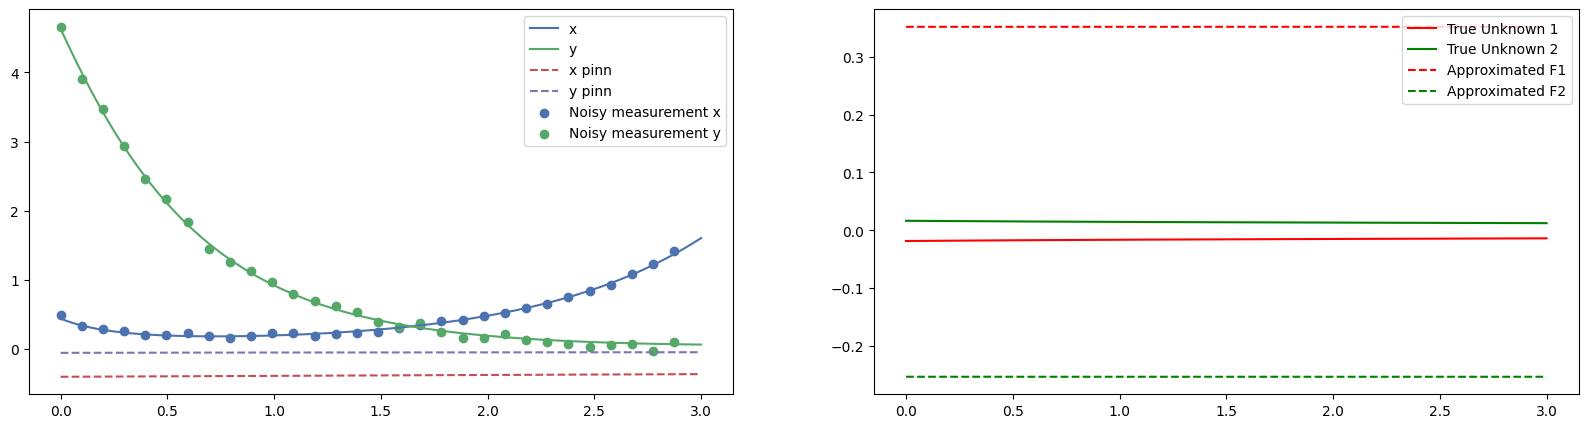

[===                 ] 16%[2000/12001] Overall:0.03662226349115372, Physics loss: 0.0009057506686076522, Datapoint loss: 0.0025812259409576654, Boundary loss: 0.0001752496464177966
MSE between F and expected unknown: 0.03904842585325241


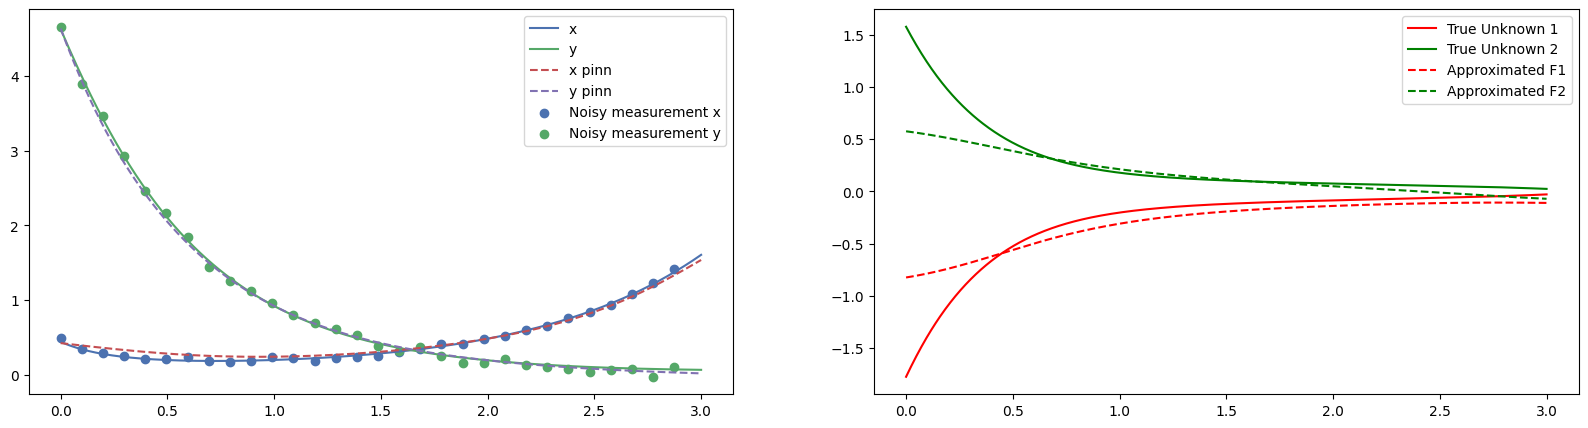

[======              ] 33%[4000/12001] Overall:0.01345609501004219, Physics loss: 2.9160966732888483e-05, Datapoint loss: 0.0013121732044965029, Boundary loss: 4.275346327631269e-06
MSE between F and expected unknown: 0.01504706172272563


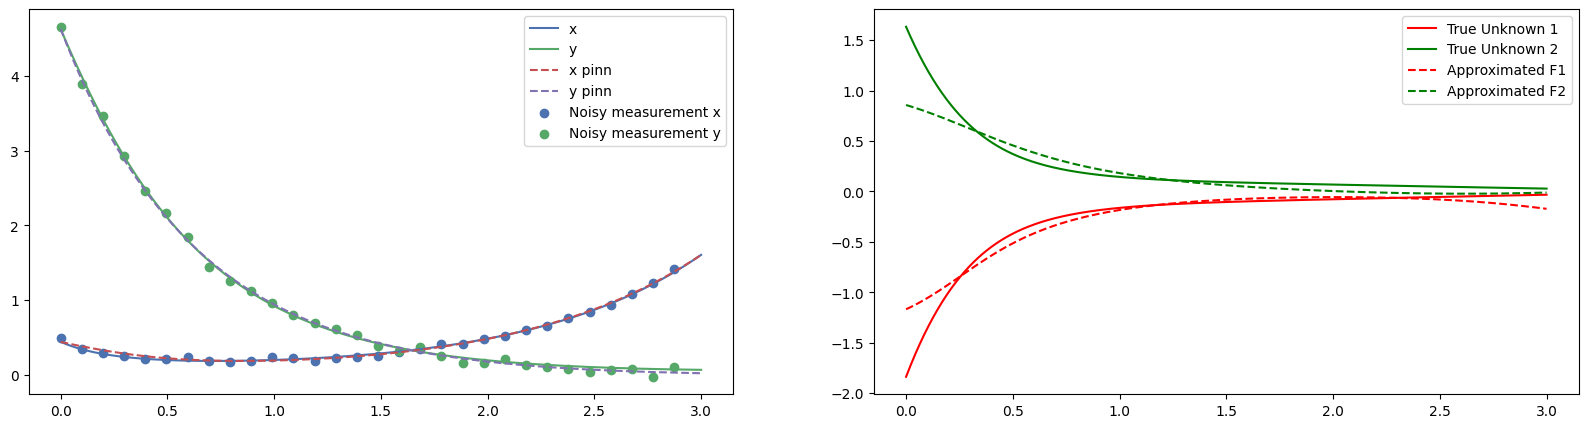

[==========          ] 49%[6000/12001] Overall:0.012017082422971725, Physics loss: 1.158677514467854e-05, Datapoint loss: 0.0011890300083905458, Boundary loss: 1.0915302937064553e-06
MSE between F and expected unknown: 0.0077223703265190125


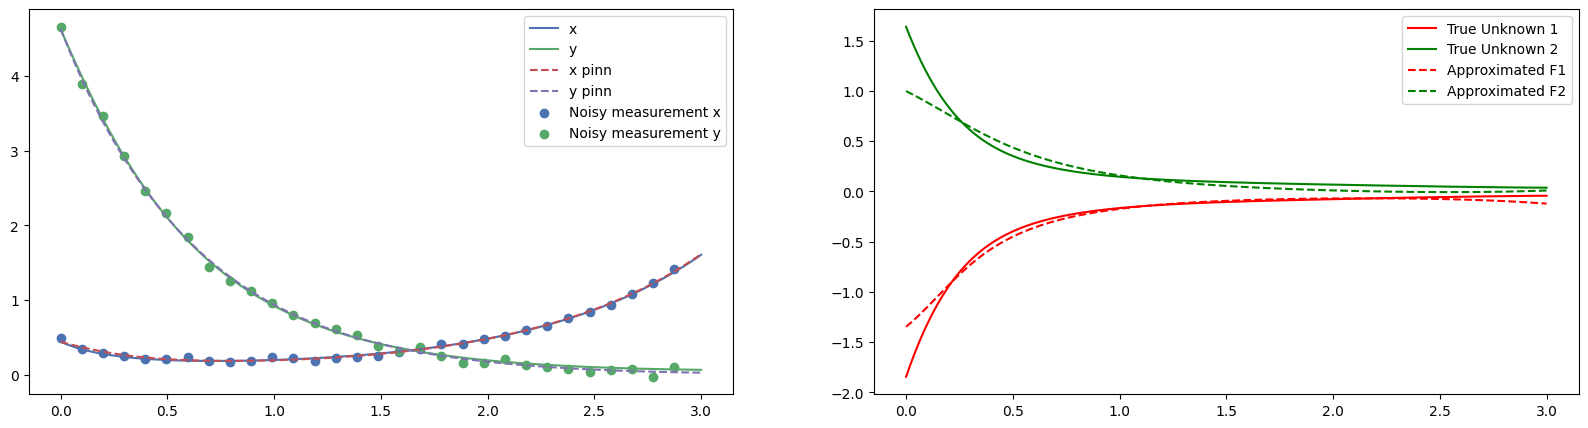

[=============       ] 66%[8000/12001] Overall:0.011609705165028572, Physics loss: 8.38242340250872e-06, Datapoint loss: 0.0011518314713612199, Boundary loss: 7.56662529965979e-07
MSE between F and expected unknown: 0.00485544849652797


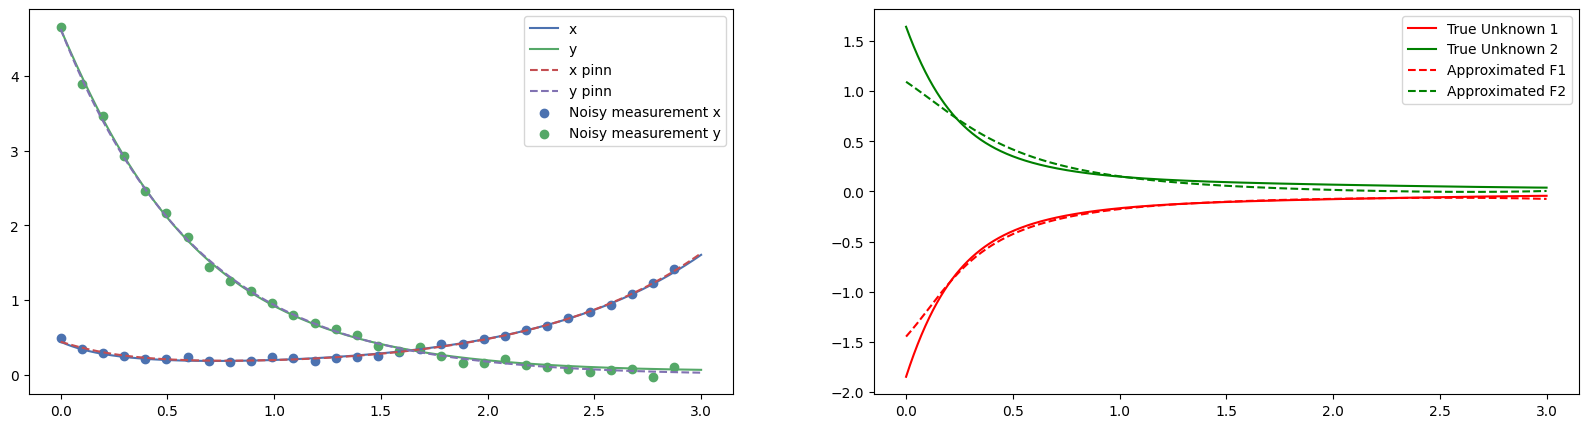

[================    ] 83%[10000/12001] Overall:0.011456985957920551, Physics loss: 6.865941031719558e-06, Datapoint loss: 0.001138069317676127, Boundary loss: 7.633428822373389e-07
MSE between F and expected unknown: 0.0035243931924924254


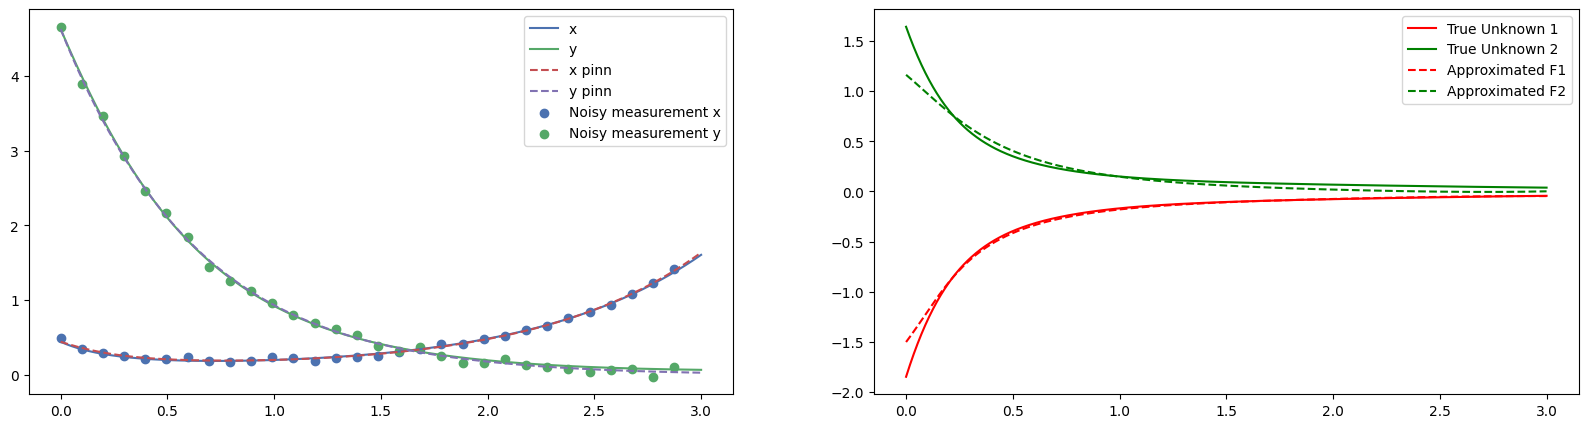

[====================] 99%[12000/12001] Overall:0.011394530534744263, Physics loss: 5.951098955847556e-06, Datapoint loss: 0.0011326954700052738, Boundary loss: 8.06454863777617e-07
MSE between F and expected unknown: 0.0028181354864500463


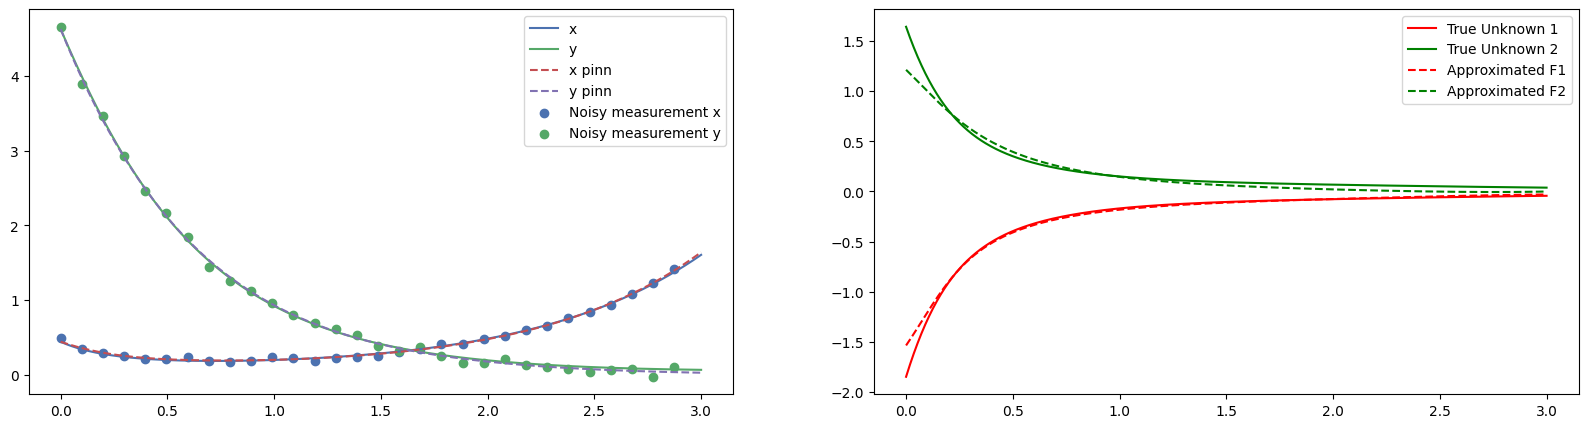

In [57]:
# Train
lr = 2e-3
optimizer = torch.optim.Adam([*u.parameters(), *f.parameters()], lr=lr)
# optim = LBFGS(net.parameters(), history_size=10, max_iter=4)
lambda1, lambda2, lambda3 = 1e1, 1e1, 1e1 # use this for high noise: 1e1, 3e1, 8e0

phys_losses = []
losses = []

total_itr = 12001
t_phys = t_phys.to(device)
for i in range(total_itr):
    optimizer.zero_grad()
    
    # boundary loss -------
    x0, y0 = LV.X
    t_boundary = 0
    u_b = u(torch.Tensor([[t_boundary]]).to(device))
    loss1 = nn.MSELoss()(u_b, torch.Tensor([[LV.X[0],LV.X[1]]]).to(device)) # ensure the initial conditions
    

    # Physics loss -------
    
    phys_input = t_phys.reshape(-1,1)
    u_p = u(phys_input)
    x, y = u_p[:,0:1], u_p[:,1:2]
    dxdt = torch.autograd.grad(x, phys_input, torch.ones_like(x), create_graph=True)[0]
    dydt = torch.autograd.grad(y, phys_input, torch.ones_like(y), create_graph=True)[0]
    

    f_p = f(u_p.to(device)) # need to detach?
    f_a, f_b = f_p[:,0].reshape(-1,1), f_p[:,1].reshape(-1,1)

    dudt = torch.hstack([dxdt - LV.alpha * x + f_a, 
                         dydt + LV.delta * y + f_b])

    loss2_1 = nn.MSELoss()(dudt[:,0].reshape(-1,1), torch.zeros_like(dudt[:,0].reshape(-1,1)))
    loss2_2 = nn.MSELoss()(dudt[:,1].reshape(-1,1), torch.zeros_like(dudt[:,1].reshape(-1,1)))
    loss2 = (loss2_1 + loss2_2)/2
    
    # Datapoint loss -------
    u_n = u(measurements_t.to(device).reshape(-1,1))
    loss3 = nn.MSELoss()(u_n, measurements.to(device).T)
    
    loss = lambda1*loss1 + lambda2*loss2  + lambda3*loss3
    
#     phys_losses.append(loss2.item())
    losses.append(loss.item())
    
    loss.backward()
    optimizer.step()
    
    sys.stdout.write("\r[%-20s] %d%%" % ('=' * (i // (total_itr // 20)), (i * 100) // total_itr))
    sys.stdout.flush()
    
    if i% 2000 == 0:
        fig_solution = plot_solution(u,f, LV)
        plt.show()
            
        

In [ ]:
# fig_solution.savefig(f'LV_exp2_sol_noise={eps}.pdf')

MSE between F and expected unknown: 0.0028181354864500463


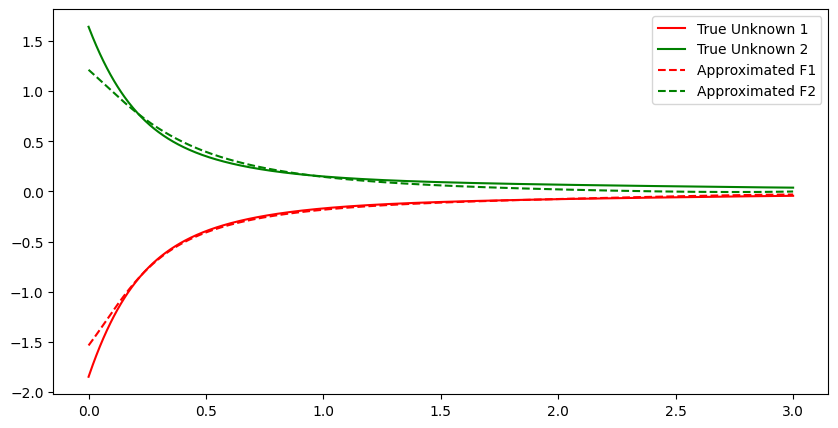

In [58]:
fig_F = test_f(LV)

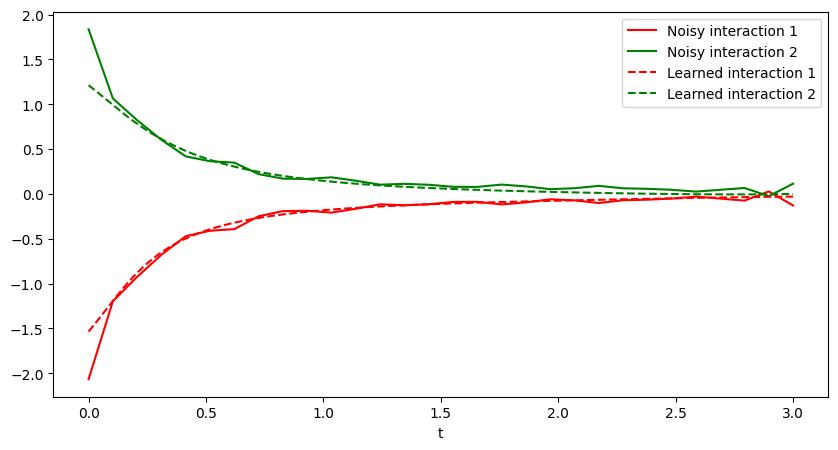

In [59]:
# Plot the noisy interaction

fig, ax = plt.subplots(1, figsize=(10,5))
ax.plot(np.linspace(0,3, measurements[0,:].shape[0]), -LV.beta * measurements[0,:]*measurements[1,:], 
        color='red', label='Noisy interaction 1')
ax.plot(np.linspace(0,3, measurements[0,:].shape[0]), LV.gamma * measurements[0,:]*measurements[1,:], 
        color='green', label='Noisy interaction 2')
ax.plot(np.linspace(0,3, f_a.shape[0]), -f_a.detach().cpu().numpy(), 
        color='red', linestyle='--', label='Learned interaction 1')
ax.plot(np.linspace(0,3, f_b.shape[0]), -f_b.detach().cpu().numpy(), 
        color='green', linestyle='--', label='Learned interaction 2')
ax.set_xlabel('t')
ax.legend()
# fig.savefig(f'./learned_vs_noisy_interaction_eps={eps}.pdf')

In [ ]:
# fig_F.savefig('./LV_F_Nd=1_Nd=100.pdf')

In [ ]:
# extent = ax[0].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
# fig.savefig('./LV_U_Nd=10_Nd=10000_nonoise.pdf', bbox_inches=extent.expanded(1.1, 1.2))

In [ ]:
# torch.save(u.state_dict(), f'U_LV_exp2_sol_noise={eps}_space={spacing}.pt')
# torch.save(f.state_dict(), f'F_LV_exp2_sol_noise={eps}_space={spacing}.pt')

In [ ]:
torch.save(u.state_dict(), 'u_Nd=1_Nd=100_nonoise.pt')
torch.save(f.state_dict(), 'f_Nd=1_Nd=100_nonoise.pt')